# Week 9: Dropout

In [13]:
# Load the dataset...
import torch
from pathlib import Path
from torch import nn
import sys
import numpy as np
from sklearn.datasets import fetch_openml
import torch.utils.data as data_utils
from sklearn.model_selection import train_test_split
from torch import optim
import matplotlib.pyplot as plt
import torchvision
from torchvision import transforms

%matplotlib inline

if("dataset" not in globals()):
    root_dir = Path().resolve()
    dataset = torchvision.datasets.MNIST(root_dir, download=True, transform=transforms.ToTensor())
    train, test = torch.utils.data.random_split(dataset, [int(len(dataset) * 0.8), int(len(dataset) * 0.2)])

First, load in MNIST and display a character:

Image Size: (1, 28, 28)


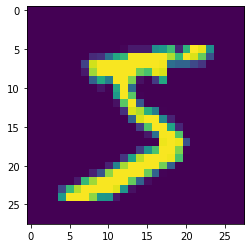

In [14]:
%matplotlib inline
print("Image Size:", tuple(dataset[0][0].shape))
plt.imshow(dataset[0][0].moveaxis(0, -1))

In [15]:
is_cuda = torch.cuda.is_available()

if is_cuda:
    device = torch.device("cuda") # GPU
else:
    device = torch.device("cpu") # CPU
    
print(f"Running PyTorch Using: {device}")

Running PyTorch Using: cpu


In [16]:
batch_size = 120

to_device = lambda a: a.to(device)

test_loader = torch.utils.data.DataLoader(test, batch_size, shuffle=True)
train_loader = torch.utils.data.DataLoader(train, batch_size, shuffle=True)

In [17]:
# Function for plotting accuracy
def plot_accuracy(train_accuracy,test_accuracy):
    plt.plot(train_accuracy,label='train')
    plt.plot(test_accuracy,label='test')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

# Functions for training a model...
def train_model(
    model, 
    train_data, 
    test_data, 
    optimizer, 
    error_func, 
    n_epochs,
    device,
    print_every=100,
    print_accuracy=True
):
    train_accuracy = []
    test_accuracy = []
    for epoch_i in range(1, n_epochs + 1):
        model.train()
        for i, (img, label) in enumerate(train_data, 1):
            # Zero gradients...
            model.zero_grad()
            # Run model...
            predicted = model.forward(img.to(device))
            
            # Compute loss, backpropigate, and optimize the weights...
            loss = error_func(predicted, label.to(device))
            loss.backward()
            optimizer.step()
            
            if((i % print_every == 0) or (i == len(train_data))):
                print(f"Epoch: {epoch_i}/{n_epochs}, Iter: {i}/{len(train_data)}, Loss: {loss:.04f}")
                
        # Run against the test set and train set at the end of each epoch to get accuracy...
        if(print_accuracy):
            model.eval()
            acc1 = get_accuracy(model, train_data)
            print(f"Epoch {epoch_i} Train Accuracy: {acc1 * 100:.02f}%")
            acc2 = get_accuracy(model, test_data)
            print(f"Epoch {epoch_i} Test Accuracy: {acc2 * 100:.02f}%\n")
            train_accuracy.append(acc1)
            test_accuracy.append(acc2)
    
    plot_accuracy(train_accuracy,test_accuracy)
    return model
        
        
def get_accuracy(model, data):
        run = 0
        correct = 0
        
        for img, label in data:
            run += len(img)
            result = model.forward(img.to(device)).cpu().detach().numpy()
            correct += np.sum(np.argmax(result, axis=1) == label.cpu().detach().numpy())
        
        return correct / run

### Model Without Dropout

Our first model will be a regular MLP classifying MNIST digits without dropout. Recall that in this network, all neurons (or nodes) will be present for every training case.

In [18]:
class VanillaNN(nn.Module):
    def __init__(self, input_size: tuple, hidden_layer_sizes: list, class_count: int): 
        super().__init__()
        layers = [
            nn.Linear(np.prod(input_size), hidden_layer_sizes[0]),
            nn.LeakyReLU()
        ]
        
        for this_size, next_size in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:]):
            layers.extend([
                nn.Linear(this_size, next_size),
                nn.LeakyReLU()
            ])
            
        layers.append(nn.Linear(hidden_layer_sizes[-1], class_count))
        
        self._linear_layers = nn.Sequential(*layers)
        self._softmax = nn.Softmax(-1)
        
    def linear_layer(self, index: int):
        return self._linear_layers[index * 2]
        
    def forward(self, x: torch.tensor, exec_depth: int = None) -> torch.tensor:
        if(exec_depth is None):
            return self._softmax(self._linear_layers(x.reshape(x.shape[0], -1)))
        else:
            # Return internal values exec_layers layers in...
            return self._linear_layers[:exec_depth * 2](x.reshape(x.shape[0], -1))

In [19]:
#TODO: Below, set the number of hidden units per layer and number of output classes
hidden_layers = [256,180,128] # this should be an array with units per hidden layer
num_classes = 10

vnn = VanillaNN(dataset[0][0].shape, hidden_layers, num_classes).to(device)
print(vnn)

VanillaNN(
  (_linear_layers): Sequential(
    (0): Linear(in_features=784, out_features=256, bias=True)
    (1): LeakyReLU(negative_slope=0.01)
    (2): Linear(in_features=256, out_features=180, bias=True)
    (3): LeakyReLU(negative_slope=0.01)
    (4): Linear(in_features=180, out_features=128, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Linear(in_features=128, out_features=10, bias=True)
  )
  (_softmax): Softmax(dim=-1)
)


In [20]:
# TODO: Set epochs and learning rate. Be sure the network's performance has begun to plateau for a good comparison
n_epochs = 40
lr = 1e-4

# Set up everything...
optimizer = optim.Adam(vnn.parameters(), lr=lr)
loss_func = nn.CrossEntropyLoss()

Epoch: 1/40, Iter: 100/400, Loss: 2.1756
Epoch: 1/40, Iter: 200/400, Loss: 1.7277
Epoch: 1/40, Iter: 300/400, Loss: 1.6968
Epoch: 1/40, Iter: 400/400, Loss: 1.6751
Epoch 1 Train Accuracy: 84.70%
Epoch 1 Test Accuracy: 84.78%

Epoch: 2/40, Iter: 100/400, Loss: 1.6225
Epoch: 2/40, Iter: 200/400, Loss: 1.6095
Epoch: 2/40, Iter: 300/400, Loss: 1.5658
Epoch: 2/40, Iter: 400/400, Loss: 1.5718
Epoch 2 Train Accuracy: 89.76%
Epoch 2 Test Accuracy: 89.64%

Epoch: 3/40, Iter: 100/400, Loss: 1.5720
Epoch: 3/40, Iter: 200/400, Loss: 1.5947
Epoch: 3/40, Iter: 300/400, Loss: 1.5419
Epoch: 3/40, Iter: 400/400, Loss: 1.5676
Epoch 3 Train Accuracy: 91.11%
Epoch 3 Test Accuracy: 90.88%

Epoch: 4/40, Iter: 100/400, Loss: 1.5625
Epoch: 4/40, Iter: 200/400, Loss: 1.5536
Epoch: 4/40, Iter: 300/400, Loss: 1.5572
Epoch: 4/40, Iter: 400/400, Loss: 1.5569
Epoch 4 Train Accuracy: 91.81%
Epoch 4 Test Accuracy: 91.61%

Epoch: 5/40, Iter: 100/400, Loss: 1.5307
Epoch: 5/40, Iter: 200/400, Loss: 1.5479
Epoch: 5/40, I

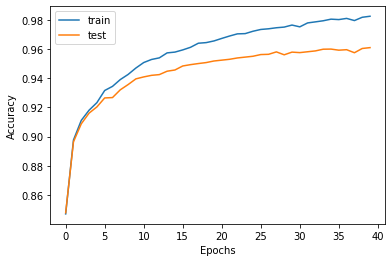

In [21]:
vnn = train_model(vnn, train_loader, test_loader, optimizer, loss_func, n_epochs, device)

In [22]:
print(f"Final Model Test Accuracy: {get_accuracy(vnn, test_loader) * 100:.02f}%")

Final Model Test Accuracy: 96.10%


> Parameters:  
> * hidden_layers = [64,64,64]  
> * epochs = 10  
> * lr = 1e-3  
> Epoch 10 Train Accuracy: 93.08%  
> Epoch 10 Test Accuracy: 92.92%
> 
> Parameters:  
> * hidden_layers = [1000,1000,1000]  
> * epochs = 10  
> * lr = 1e-3  
> Epoch 10 Train Accuracy: 91.27%  
> Epoch 10 Test Accuracy: 91.33%  
> Time: 7m 25s
>  
> Parameters:  
> * hidden_layers = [256,128,128]  
> * epochs = 10  
> * lr = 1e-3  
> Epoch 10 Train Accuracy: 98.09%  
> Epoch 10 Test Accuracy: 96.81%  
> Time: 3m 1s
>  
> Final Model:  
> Parameters:  
> * hidden_layers = [256,128,128]  
> * epochs = 40  
> * lr = 1e-4  
> Epoch 10 Train Accuracy: 98.25%  
> Epoch 10 Test Accuracy: 96.10%  
> Time: 11m 35s

### Model With Dropout

Now, let's try the same network with dropout. Dropout is simple: For every layer, the input to any given neuron is zeroed out with probability *p*. When a neuron's input is zeroed out, it's effectively removed from the model. Which neurons are dropped are determined by a vector of 1's and 0's generated by a Bernoulli distribution (at least, in the paper) for each training case.

Notably, dropout effectively turns a single model into an ensemble of models that share weights, where each model in the ensemble is a random subnetwork that only rarely gets trained.

**TODO: How many subnetworks are possible in a network with *n* units?**
> 2^n

**TODO: How does dropout change the relationship of units in the network with their neighbors?**
> They can't always rely on their neighbours being able to share the task of learning so they learn to do more specific tasks. This is shown by the display of node weights in the paper: there are spots of higher contrast in the visualised dropout network weights when compared to the non-dropout network weights.

In [23]:
class DropoutNN(nn.Module):
    def __init__(
        self, 
        input_size: tuple, 
        hidden_layer_sizes: list, 
        dropout_values: list, 
        class_count: int
    ):
        super().__init__()
        layers = [
            #TODO: Add dropout here (hint: there's a PyTorch function for it).
            #Which value from the dropout list should go here?
            nn.Dropout(dropout_values[0]),
            nn.Linear(np.prod(input_size), hidden_layer_sizes[0]),
            nn.LeakyReLU()
        ]
        
        for this_size, next_size, dv in zip(hidden_layer_sizes[:-1], hidden_layer_sizes[1:], dropout_values[1:]):
            layers.extend([
                #TODO: Add dropout here too
                nn.Dropout(dv),
                nn.Linear(this_size, next_size),
                nn.LeakyReLU()
            ])
            
        layers.extend([
            #TODO: Last dropout call here. Which value should it take?
            nn.Dropout(dropout_values[-1]),
            nn.Linear(hidden_layer_sizes[-1], class_count)
        ])
        
        self._linear_layers = nn.Sequential(*layers)
        self._softmax = nn.Softmax(-1)
        
    def linear_layer(self, index: int):
        return self._linear_layers[index * 3 + 1]
        
    def forward(self, x: torch.tensor, exec_depth: int = None) -> torch.tensor:
        if(exec_depth is None):
            return self._softmax(self._linear_layers(x.reshape(x.shape[0], -1)))
        else:
            # Return internal values exec_layers layers in...
            return self._linear_layers[:exec_depth * 3](x.reshape(x.shape[0], -1))

In [24]:
# TODO: Specify number of hidden units per layer, per-layer dropout probability (between 0 and 1), and number of 
# output classes. How many per-layer dropout probabilities does this model require?
hidden_layers = [256,180,128]
dropout_probs = [0.2,0.4,0.4,0.3]
num_classes = 10

dnn = DropoutNN(dataset[0][0].shape, hidden_layers, dropout_probs, num_classes).to(device)
print(dnn)

DropoutNN(
  (_linear_layers): Sequential(
    (0): Dropout(p=0.2, inplace=False)
    (1): Linear(in_features=784, out_features=256, bias=True)
    (2): LeakyReLU(negative_slope=0.01)
    (3): Dropout(p=0.4, inplace=False)
    (4): Linear(in_features=256, out_features=180, bias=True)
    (5): LeakyReLU(negative_slope=0.01)
    (6): Dropout(p=0.4, inplace=False)
    (7): Linear(in_features=180, out_features=128, bias=True)
    (8): LeakyReLU(negative_slope=0.01)
    (9): Dropout(p=0.3, inplace=False)
    (10): Linear(in_features=128, out_features=10, bias=True)
  )
  (_softmax): Softmax(dim=-1)
)


In [25]:
# TODO: Set epochs and learning rate. Note that dropout substantially slows down training!
n_epochs2 = 40
lr2 = 1e-4

# Set up everything...
optimizer2 = optim.Adam(dnn.parameters(), lr=lr2)
loss_func2 = nn.CrossEntropyLoss()

Epoch: 1/40, Iter: 100/400, Loss: 2.2635
Epoch: 1/40, Iter: 200/400, Loss: 1.9973
Epoch: 1/40, Iter: 300/400, Loss: 1.8239
Epoch: 1/40, Iter: 400/400, Loss: 1.7330
Epoch 1 Train Accuracy: 78.21%
Epoch 1 Test Accuracy: 77.60%

Epoch: 2/40, Iter: 100/400, Loss: 1.6872
Epoch: 2/40, Iter: 200/400, Loss: 1.6846
Epoch: 2/40, Iter: 300/400, Loss: 1.7369
Epoch: 2/40, Iter: 400/400, Loss: 1.6823
Epoch 2 Train Accuracy: 82.52%
Epoch 2 Test Accuracy: 81.82%

Epoch: 3/40, Iter: 100/400, Loss: 1.6887
Epoch: 3/40, Iter: 200/400, Loss: 1.6015
Epoch: 3/40, Iter: 300/400, Loss: 1.6717
Epoch: 3/40, Iter: 400/400, Loss: 1.5569
Epoch 3 Train Accuracy: 88.39%
Epoch 3 Test Accuracy: 88.22%

Epoch: 4/40, Iter: 100/400, Loss: 1.6061
Epoch: 4/40, Iter: 200/400, Loss: 1.5916
Epoch: 4/40, Iter: 300/400, Loss: 1.6349
Epoch: 4/40, Iter: 400/400, Loss: 1.6191
Epoch 4 Train Accuracy: 89.80%
Epoch 4 Test Accuracy: 89.75%

Epoch: 5/40, Iter: 100/400, Loss: 1.6032
Epoch: 5/40, Iter: 200/400, Loss: 1.5964
Epoch: 5/40, I

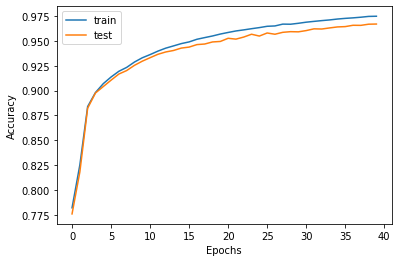

In [26]:
dnn = train_model(dnn, train_loader, test_loader, optimizer2, loss_func2, n_epochs2, device)

In [27]:
dnn.eval()
print(f"Final Model Test Accuracy: {get_accuracy(dnn, test_loader) * 100:.02f}%")

Final Model Test Accuracy: 96.68%


> Parameters:  
> * hidden_layers = [64,64,64]  
> * dropout_probs = [0.2,0.4,0.5,0.3]  
> * epochs = 10  
> * lr = 1e-3  
> Epoch 10 Train Accuracy: 93.08%  
> Epoch 10 Test Accuracy: 92.92%
> 
> Parameters:  
> * hidden_layers = [84,128,84]  
> * dropout_probs = [0.2,0.4,0.4,0.3]  
> * epochs = 10  
> * lr = 1e-3  
> Epoch 10 Train Accuracy: 94.76%  
> Epoch 10 Test Accuracy: 94.24%     
>  
> Parameters:  
> * hidden_layers = [1000,1000,1000]  
> * dropout_probs = [0.2,0.2,0.5,0.5]  
> * epochs = 10  
> * lr = 1e-3  
> Epoch 10 Train Accuracy: 90.39%
> Epoch 10 Test Accuracy: 90.44%  
> Time: 6m 41s  

In the interest of time: if the dropout model performs slightly worse than or equivalent to the vanilla model, there should still be clear differences in the layers visualized below. If you have the time, experiment with the number of epochs, learning rate, and dropout probabillities to maximize the dropout model's performance, then compare against the vanilla model.

**TODO: How does the training rate of the dropout model compare to the vanilla model? Why does dropout have this effect on training rates?**
> With the larger network (described above), convergence was more erratic. The accuracy jumped around a lot! For both the vanilla and dropout implementations, the accuracy hovered around 90%. For a large network, the dropout network trained a bit faster and converged better/faster, whereas the vanilla network was more erratic.  
>
> So what I did was chose a middle ground for the network size.  
>
> Parameters:  
> * hidden_layers = [84,128,84]  
> * dropout_probs = [0.2,0.4,0.4,0.3]  
> * epochs = 10  
> * lr = 1e-3  
> Epoch 10 Train Accuracy: 96.97%  
> Epoch 10 Test Accuracy: 96.48%  
> Time: 3m 8s
>
> With that success I decided to up the network size a bit, the learning rate, and  the number of epochs and rerun this from the beginning while plotting accuracy:  
> Parameters:  
> * hidden_layers = [256,180,128]  
> * dropout_probs = [0.2,0.4,0.4,0.3]  
> * epochs = 40  
> * lr = 1e-4  
> Epoch 10 Train Accuracy: 97.47%  
> Epoch 10 Test Accuracy: 96.68%  
> Time: 12m 25s
> 
> I noticed it took longer to train the network with dropout and it took longer to converge. The final results were similar.

### Visualizing Model Layers

Now, let's visualize the first layer weights from both models:

In [28]:
def plot_first_hidden_layer(
    model: nn.Module, 
    title: str, 
    height: int, 
    width: int, 
    depth: int, 
    num_samples: int = 10
):
    # Get the weights...
    weight = model.linear_layer(0).weight
    # Detach them and reshape them into the image size...
    weight = weight.cpu().detach().numpy().reshape(-1, depth, height, width)
        
    fig, axs = plt.subplots(depth, num_samples, squeeze=False)
    fig.set_size_inches(3 * num_samples, 3 * depth)
    fig.suptitle(title)
    
    selected_filters = np.random.choice(len(weight), num_samples, replace=False)
    for i, sub_axs in zip(selected_filters, axs.T):
        img = weight[i]
        
        for j, ax in enumerate(sub_axs):
            ax.set_title(f"Cell {i}, Channel {j}")
            ax.imshow(img[j])
    
    fig.tight_layout()
    fig.show()

C:\Users\PRIMEL~1\AppData\Local\Temp/ipykernel_12240/982768779.py:27: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


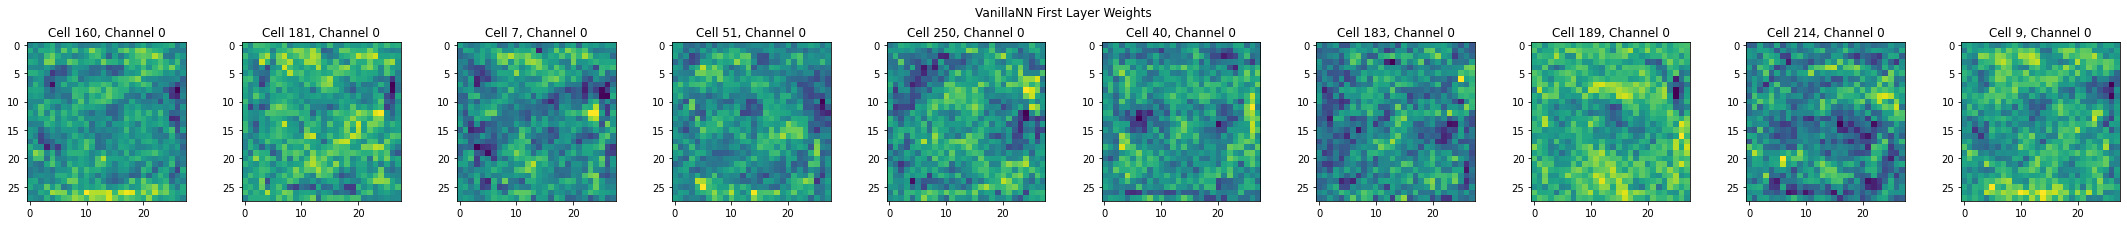

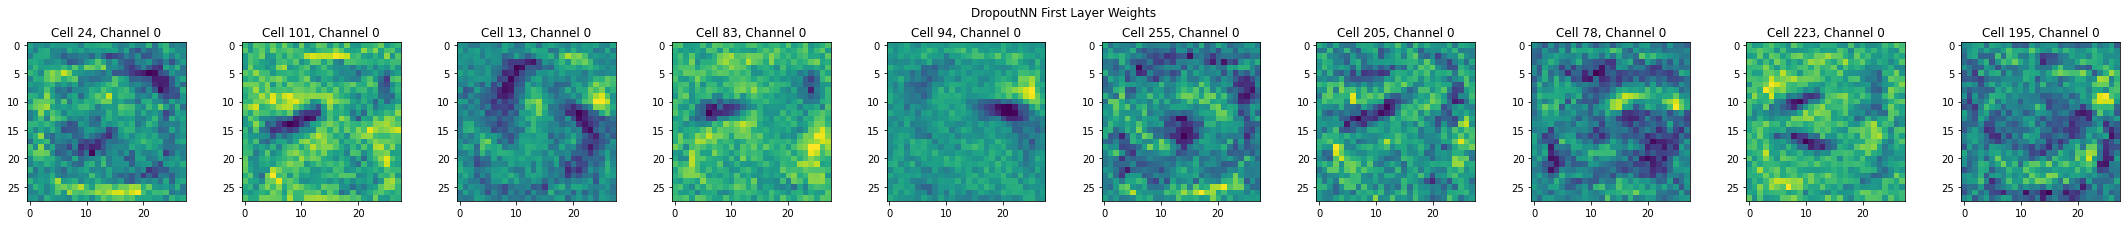

In [29]:
%matplotlib inline

d, h, w = dataset[0][0].shape
plot_first_hidden_layer(vnn, "VanillaNN First Layer Weights", h, w, d)
plot_first_hidden_layer(dnn, "DropoutNN First Layer Weights", h, w, d)

Double click on each row of plots to make them larger!

**TODO: Are there visual differences between the vanilla and dropout model weights? How does dropout cause these differences in the weights?**  
> I couldn't really see a difference with 10 epochs:  
<p align="center">
    <img src="output_0.png" \>
    <img src="output_0-dropout.png" \>
</p>

> I though perhaps there will be a difference between the images as the number of epochs increases, so I reran the experiment with 40 epochs. The result can be seen above these last images. Some of the  images seem to have a little less graininess, but overall they are still similar.   

# Optimal Images 

Below, we choose random individual neurons from the 'vanilla' net and the dropout net. For each neuron, we train an optimal image to maximally activate its neuron, then display the optimal image.

In [43]:
def generate_optimal_image(
    model: nn.Module,
    run_through_layers: int,
    nodes: int,
    width: int,
    height: int,
    depth: int,
    device,
    learning_rate: int = 5e-4,
    epochs: int = 4500,
    optimize_range: bool = False
) -> np.ndarray:
    # Put model in evaluation mode, we only want to optimize the image...
    model.eval()
    # Create a random image...
    img = torch.randn(1, depth, height, width, device=device, requires_grad=True)
    optimizer = optim.Adam([img], lr=learning_rate)
    loss_func = nn.MSELoss()
    
    print(f"Optimize Values After Layer {model.linear_layer(run_through_layers - 1)}, Node: {nodes}")
    
    for i in range(epochs):
        # Zero gradients...
        if img.grad is not None:
            img.grad.detach_()
            img.grad.zero_()
        model.zero_grad()
        # Run model...
        predicted = model.forward(img, run_through_layers)
        
        mask = np.zeros(predicted.shape[1], bool)
        mask[nodes] = 1
        
        node_score = torch.min(predicted[0, mask])
        not_node_score = torch.max(predicted[0, ~mask])
        
        # Compute loss, backpropigate, and optimize the weights...
        # Our loss: Maximize the range between nodes of interest and other nodes
        loss = -node_score if(not optimize_range) else -node_score + not_node_score
        
        loss.backward()
        optimizer.step()
        
        # All images are made up of channels that range from 0 to 1, so clamp values within that range...
        with torch.no_grad():
            img.clamp_(0, 1)

        if((i % 500 == 0) or (i == (epochs - 1))):
            print(f"Epoch: {i}/{epochs}, Loss: {loss:.02f}")
            
    return img

def random_optimal_images_from(
    model: nn.Module, 
    layer: int, 
    num_samples: int,
    width: int, 
    height: int, 
    depth: int, 
    device,
    *args,
    **kwargs
) -> tuple:
    imgs = []
    samples = np.random.choice(model.linear_layer(layer - 1).weight.shape[0], num_samples, replace=False)
    
    for i, sample in enumerate(samples):
        print(f"Working on image {i + 1}/{num_samples}")
        imgs.append(
            generate_optimal_image(model, layer, sample, height, width, depth, device, *args, **kwargs)
        )
    
    fig, axs = plt.subplots(depth, num_samples, squeeze=False)
    fig.set_size_inches(3 * num_samples, 3 * depth)
    fig.suptitle(type(model).__name__)
    
    for img, sample_i, sub_axs in zip(imgs, samples, axs.T):
        for j, ax in enumerate(sub_axs):
            img2 = img.cpu().detach().numpy()[0, j]
            ax.set_title(f"Layer {layer}, Node {sample_i}, Channel {j}")
            m = ax.imshow(img2, cmap="plasma") 
    
    fig.colorbar(m)
    fig.tight_layout()
    # fig.show()
    
    return fig, axs, imgs, samples

Working on image 1/10
Optimize Values After Layer Linear(in_features=128, out_features=10, bias=True), Node: 1
Epoch: 0/4500, Loss: 3.99
Epoch: 500/4500, Loss: 12.77
Epoch: 1000/4500, Loss: -9.66
Epoch: 1500/4500, Loss: -24.04
Epoch: 2000/4500, Loss: -35.08
Epoch: 2500/4500, Loss: -45.79
Epoch: 3000/4500, Loss: -52.84
Epoch: 3500/4500, Loss: -57.32
Epoch: 4000/4500, Loss: -60.47
Epoch: 4499/4500, Loss: -62.52
Working on image 2/10
Optimize Values After Layer Linear(in_features=128, out_features=10, bias=True), Node: 7
Epoch: 0/4500, Loss: -18.56
Epoch: 500/4500, Loss: -26.89
Epoch: 1000/4500, Loss: -58.26
Epoch: 1500/4500, Loss: -79.42
Epoch: 2000/4500, Loss: -97.94
Epoch: 2500/4500, Loss: -110.82
Epoch: 3000/4500, Loss: -117.24
Epoch: 3500/4500, Loss: -120.79
Epoch: 4000/4500, Loss: -122.80
Epoch: 4499/4500, Loss: -124.09
Working on image 3/10
Optimize Values After Layer Linear(in_features=128, out_features=10, bias=True), Node: 4
Epoch: 0/4500, Loss: 19.57
Epoch: 500/4500, Loss: -20.

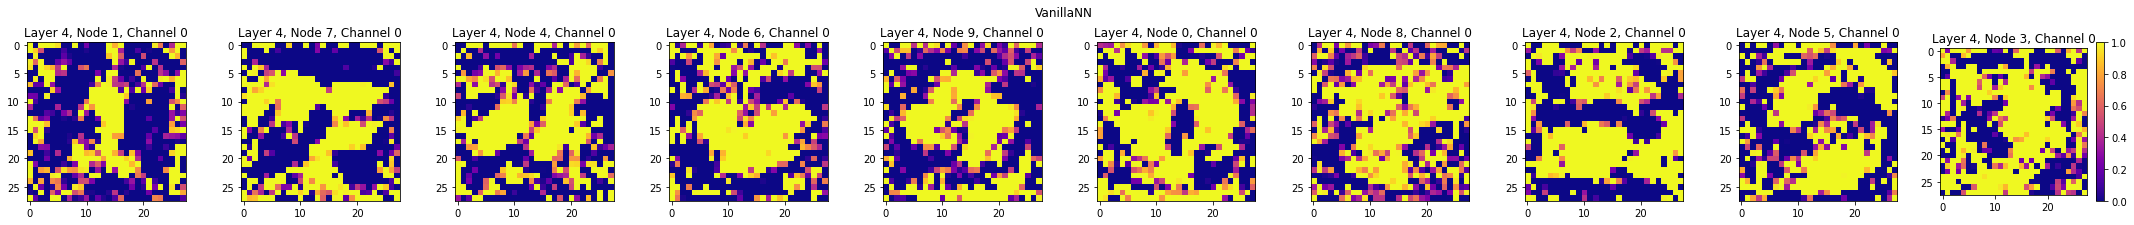

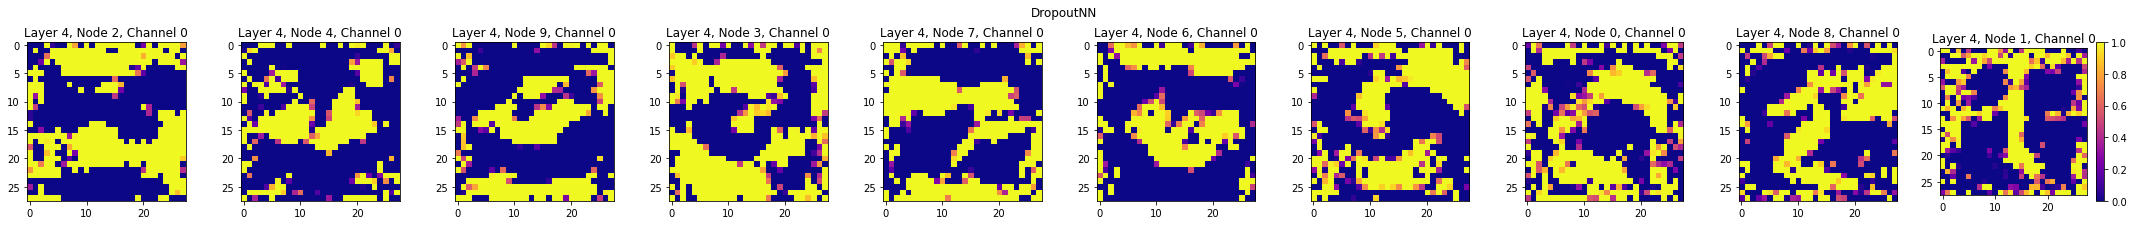

In [44]:

vanilla_res = random_optimal_images_from(vnn, 4, 10, h, w, d, device, optimize_range=True)[0]
dropout_res = random_optimal_images_from(dnn, 4, 10, h, w, d, device, optimize_range=True)[0]

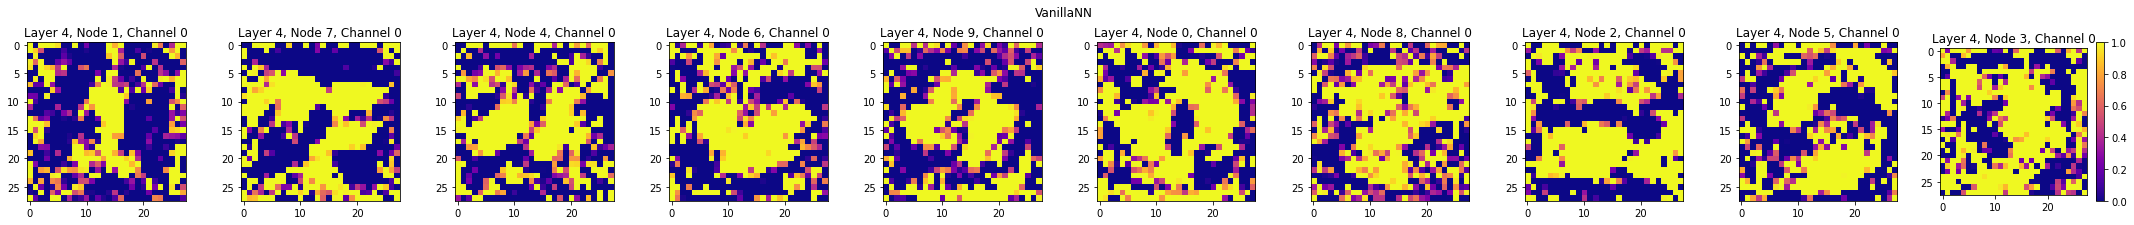

In [45]:

vanilla_res

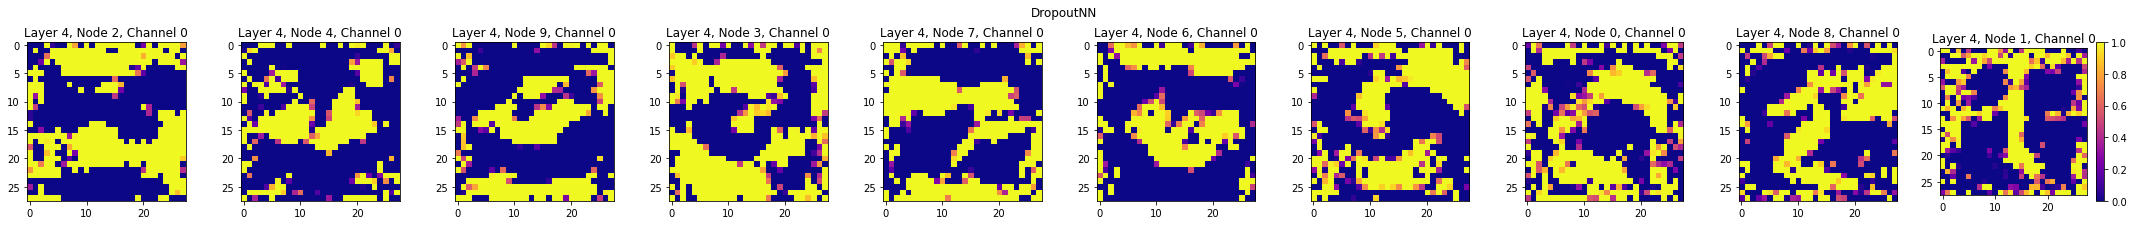

In [46]:

dropout_res

**TODO: Are there any differences between the 'vanilla' net optimal images and the dropout net optimal images? If so, what do you think led to these differences?**
> The vanilla images have more pixels spread across the value spectrum whereas the dropout images have more extremes in the pixel values - this relates to what I was saying earlier about greater contrast in the visualised nodes that were shown in the paper. The nodes are learning to do more specific tasks, or in other words they are activating much more specifically on certain areas and their activation is less generalised than in the vanilla nodes. 


Working on image 1/3
Optimize Values After Layer Linear(in_features=784, out_features=256, bias=True), Node: 93
Epoch: 0/4500, Loss: 4.04
Epoch: 500/4500, Loss: 0.27
Epoch: 1000/4500, Loss: -2.40
Epoch: 1500/4500, Loss: -4.33
Epoch: 2000/4500, Loss: -5.95
Epoch: 2500/4500, Loss: -6.84
Epoch: 3000/4500, Loss: -7.21
Epoch: 3500/4500, Loss: -7.41
Epoch: 4000/4500, Loss: -7.52
Epoch: 4499/4500, Loss: -7.58
Working on image 2/3
Optimize Values After Layer Linear(in_features=784, out_features=256, bias=True), Node: 153
Epoch: 0/4500, Loss: 2.18
Epoch: 500/4500, Loss: 1.94
Epoch: 1000/4500, Loss: -1.69
Epoch: 1500/4500, Loss: -3.79
Epoch: 2000/4500, Loss: -5.19
Epoch: 2500/4500, Loss: -6.21
Epoch: 3000/4500, Loss: -6.83
Epoch: 3500/4500, Loss: -7.15
Epoch: 4000/4500, Loss: -7.31
Epoch: 4499/4500, Loss: -7.42
Working on image 3/3
Optimize Values After Layer Linear(in_features=784, out_features=256, bias=True), Node: 225
Epoch: 0/4500, Loss: 2.70
Epoch: 500/4500, Loss: 0.70
Epoch: 1000/4500, Lo

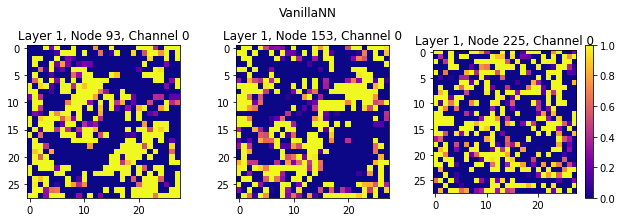

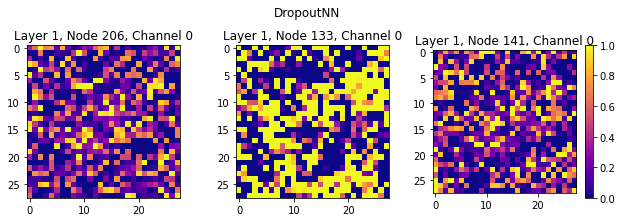

In [47]:
vanilla_res = random_optimal_images_from(vnn, 1, 3, h, w, d, device, optimize_range=True)[0]
dropout_res = random_optimal_images_from(dnn, 1, 3, h, w, d, device, optimize_range=True)[0]

Working on image 1/3
Optimize Values After Layer Linear(in_features=256, out_features=180, bias=True), Node: 116
Epoch: 0/4500, Loss: 2.45
Epoch: 500/4500, Loss: 2.49
Epoch: 1000/4500, Loss: -0.07
Epoch: 1500/4500, Loss: -1.29
Epoch: 2000/4500, Loss: -1.85
Epoch: 2500/4500, Loss: -2.27
Epoch: 3000/4500, Loss: -2.63
Epoch: 3500/4500, Loss: -2.91
Epoch: 4000/4500, Loss: -3.10
Epoch: 4499/4500, Loss: -3.24
Working on image 2/3
Optimize Values After Layer Linear(in_features=256, out_features=180, bias=True), Node: 65
Epoch: 0/4500, Loss: 3.20
Epoch: 500/4500, Loss: -2.47
Epoch: 1000/4500, Loss: -4.43
Epoch: 1500/4500, Loss: -5.89
Epoch: 2000/4500, Loss: -7.18
Epoch: 2500/4500, Loss: -8.26
Epoch: 3000/4500, Loss: -8.91
Epoch: 3500/4500, Loss: -9.32
Epoch: 4000/4500, Loss: -9.56
Epoch: 4499/4500, Loss: -9.73
Working on image 3/3
Optimize Values After Layer Linear(in_features=256, out_features=180, bias=True), Node: 84
Epoch: 0/4500, Loss: 5.70
Epoch: 500/4500, Loss: 0.22
Epoch: 1000/4500, Lo

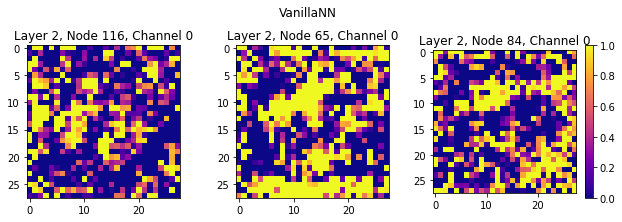

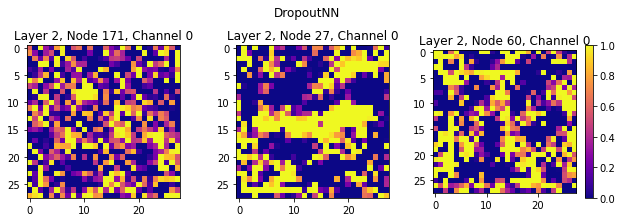

In [48]:
vanilla_res = random_optimal_images_from(vnn, 2, 3, h, w, d, device, optimize_range=True)[0]
dropout_res = random_optimal_images_from(dnn, 2, 3, h, w, d, device, optimize_range=True)[0]

Working on image 1/3
Optimize Values After Layer Linear(in_features=180, out_features=128, bias=True), Node: 120
Epoch: 0/4500, Loss: 9.72
Epoch: 500/4500, Loss: 2.58
Epoch: 1000/4500, Loss: 1.16
Epoch: 1500/4500, Loss: 0.37
Epoch: 2000/4500, Loss: -0.17
Epoch: 2500/4500, Loss: -0.55
Epoch: 3000/4500, Loss: -0.87
Epoch: 3500/4500, Loss: -1.16
Epoch: 4000/4500, Loss: -1.37
Epoch: 4499/4500, Loss: -1.57
Working on image 2/3
Optimize Values After Layer Linear(in_features=180, out_features=128, bias=True), Node: 106
Epoch: 0/4500, Loss: 7.57
Epoch: 500/4500, Loss: 4.86
Epoch: 1000/4500, Loss: 0.50
Epoch: 1500/4500, Loss: -1.35
Epoch: 2000/4500, Loss: -2.31
Epoch: 2500/4500, Loss: -2.94
Epoch: 3000/4500, Loss: -3.37
Epoch: 3500/4500, Loss: -3.81
Epoch: 4000/4500, Loss: -4.20
Epoch: 4499/4500, Loss: -4.55
Working on image 3/3
Optimize Values After Layer Linear(in_features=180, out_features=128, bias=True), Node: 83
Epoch: 0/4500, Loss: 9.46
Epoch: 500/4500, Loss: 0.19
Epoch: 1000/4500, Loss:

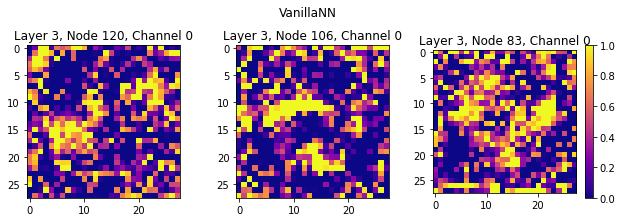

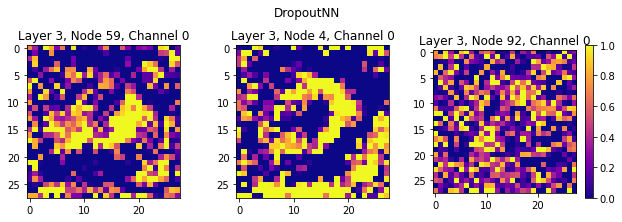

In [50]:
vanilla_res = random_optimal_images_from(vnn, 3, 3, h, w, d, device, optimize_range=True)[0]
dropout_res = random_optimal_images_from(dnn, 3, 3, h, w, d, device, optimize_range=True)[0]

Working on image 1/3
Optimize Values After Layer Linear(in_features=128, out_features=10, bias=True), Node: 5
Epoch: 0/4500, Loss: 20.91
Epoch: 500/4500, Loss: -39.46
Epoch: 1000/4500, Loss: -63.81
Epoch: 1500/4500, Loss: -87.78
Epoch: 2000/4500, Loss: -108.21
Epoch: 2500/4500, Loss: -121.75
Epoch: 3000/4500, Loss: -127.84
Epoch: 3500/4500, Loss: -131.11
Epoch: 4000/4500, Loss: -132.70
Epoch: 4499/4500, Loss: -133.67
Working on image 2/3
Optimize Values After Layer Linear(in_features=128, out_features=10, bias=True), Node: 4
Epoch: 0/4500, Loss: 61.82
Epoch: 500/4500, Loss: 2.51
Epoch: 1000/4500, Loss: -48.33
Epoch: 1500/4500, Loss: -65.12
Epoch: 2000/4500, Loss: -79.32
Epoch: 2500/4500, Loss: -91.05
Epoch: 3000/4500, Loss: -98.10
Epoch: 3500/4500, Loss: -102.01
Epoch: 4000/4500, Loss: -104.38
Epoch: 4499/4500, Loss: -105.85
Working on image 3/3
Optimize Values After Layer Linear(in_features=128, out_features=10, bias=True), Node: 8
Epoch: 0/4500, Loss: 32.73
Epoch: 500/4500, Loss: -31

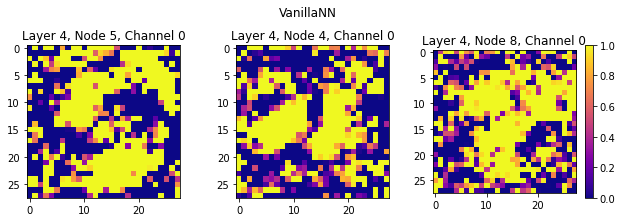

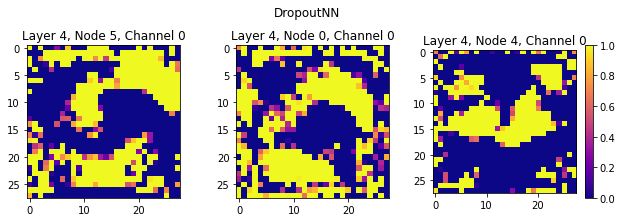

In [49]:
vanilla_res = random_optimal_images_from(vnn, 4, 3, h, w, d, device, optimize_range=True)[0]
dropout_res = random_optimal_images_from(dnn, 4, 3, h, w, d, device, optimize_range=True)[0]

**TODO: The above function allows you to randomly sample nodes from any layer of the network for generating optimal images (Currently set to layer 4, the final layer output). What results do you get when changing the layer optimal images are being generated for? How do the Vanilla NN and Dropout NN results compare and differ?**
> As you can see from the progression above where I sample from all the layers starting from 1, the nodes in the dropout network start from being far more noisy to far less noisy then the vanilla network. The middle layers have nodes that are quite similar, but the beginning and end are quite different. As to why that is the case I am not sure but I suppose it could be that the earlier layers in the network are activating on more generalised information and as the layers progress the nodes activate on increasingly specific information. The reasons for this we have discussed at length.  